<a href="https://colab.research.google.com/github/titika2013/Made_adv_DL/blob/main/homework_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
import glob
import random

import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
import torchvision
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

mpl.rcParams.update(mpl.rcParamsDefault)
import warnings

warnings.filterwarnings("ignore", category=mpl.cbook.mplDeprecation)


#### Prepare

In [3]:
from PIL import Image


def read_path(path):
    all_path = "/content/drive/MyDrive/facades/" + path + "/"
    dataset = []
    for p in glob.glob(all_path + "*.jpg"):
        dataset.append(p)
    return dataset


class Dataset(object):
    def __init__(self, path):
        self.files = read_path(path)
        self.trasformer = transforms.Compose([
            transforms.ToTensor(),
            # transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
        ])

    def _sep(self, img):
        img_np = np.array(img)
        mask_image = img_np[:, img.width // 2:]
        real_image = img_np[:, :img.width // 2]
        return mask_image, real_image

    def __getitem__(self, idx):
        img = Image.open(self.files[idx]).convert('RGB')

        real, mask = self._sep(img)
        input_tensor = self.trasformer(real)
        output_tensor = self.trasformer(mask)
        return input_tensor, output_tensor

    def __len__(self):
        return len(self.files)


def show_img_sample(mask, real):
    fig, axes = plt.subplots(1, 2, figsize=(12, 12))
    ax = axes.ravel()
    ax[0].imshow(mask.permute(1, 2, 0))
    ax[0].set_title("mask image", c="g")
    ax[1].imshow(real.permute(1, 2, 0))
    ax[1].set_title("real image", c="g")

    plt.show()


In [4]:
train_ds = Dataset("train")
val_ds = Dataset("val")
test_ds = Dataset("test")

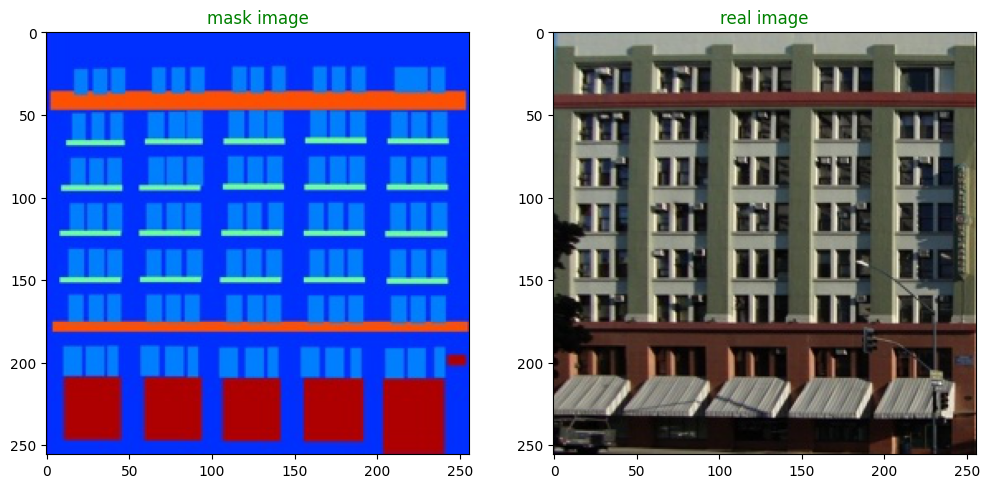

In [5]:
show_img_sample(train_ds[1][0], train_ds[1][1])

In [6]:
BATCH_SIZE = 11
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE , shuffle=True)
test_dl = DataLoader(val_ds, batch_size=1, shuffle=False)

### Pix2Pix

In [7]:
import torch
import torch.nn as nn


class batchnorm_relu_drop(nn.Module):
    def __init__(self, in_c):
        super().__init__()

        self.bn = nn.BatchNorm2d(in_c)
        self.lrelu = nn.LeakyReLU(0.2)
        self.drop = nn.Dropout(0.3)

    def forward(self, inputs):
        x = self.bn(inputs)
        x = self.lrelu(x)
        x = self.drop(x)
        return x


class res_blok(nn.Module):
    def __init__(self, in_c, out_c, stride=1):
        super().__init__()

        self.b1 = batchnorm_relu_drop(in_c)
        self.c1 = nn.Conv2d(in_c, out_c, kernel_size=3, padding=1, stride=stride)
        self.b2 = batchnorm_relu_drop(out_c)
        self.c2 = nn.Conv2d(out_c, out_c, kernel_size=3, padding=1, stride=1)

        self.s = nn.Conv2d(in_c, out_c, kernel_size=1, padding=0, stride=stride)

    def forward(self, inputs):
        x = self.b1(inputs)
        x = self.c1(x)
        x = self.b2(x)
        x = self.c2(x)
        s = self.s(inputs)

        skip = x + s
        return skip


class up_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.upsample = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        self.r = res_blok(in_c + out_c, out_c)

    def forward(self, inputs, skip):
        x = self.upsample(inputs)
        x = torch.cat([x, skip], axis=1)
        x = self.r(x)
        return x


class Generator(nn.Module):
    def __init__(self, in_c=3, out_c=64):
        super().__init__()

        """ Encoder 1 """
        self.c11 = nn.Conv2d(in_c, out_c, kernel_size=3, padding=1)
        # self.br1 = batchnorm_relu(out_c)
        """ Encoder 2 """
        self.r1 = res_blok(out_c, out_c * 2, stride=2)
        self.r2 = res_blok(out_c * 2, out_c * 4, stride=2)
        self.r3 = res_blok(out_c * 4, out_c * 8, stride=2)
        self.r4 = res_blok(out_c * 8, out_c * 8, stride=2)
        self.r5 = res_blok(out_c * 8, out_c * 8, stride=2)
        self.r6 = res_blok(out_c * 8, out_c * 8, stride=2)
        self.r7 = res_blok(out_c * 8, out_c * 8, stride=2)

        """ Decoder """
        self.d1 = up_block(out_c * 8, out_c * 8)
        self.d2 = up_block(out_c * 8, out_c * 8)
        self.d3 = up_block(out_c * 8, out_c * 8)
        self.d4 = up_block(out_c * 8, out_c * 8)
        self.d5 = up_block(out_c * 8, out_c * 4)
        self.d6 = up_block(out_c * 4, out_c * 2)
        self.d7 = up_block(out_c * 2, out_c)

        """ Output """
        self.output = nn.Conv2d(out_c, in_c, kernel_size=1)

    def forward(self, inputs):
        """ Encoder 1 """
        x = self.c11(inputs)
        # x = self.br1(x)

        """ Encoder 2 and 3 """
        skip1 = self.r1(x)
        skip2 = self.r2(skip1)
        skip3 = self.r3(skip2)
        skip4 = self.r4(skip3)
        skip5 = self.r5(skip4)
        skip6 = self.r6(skip5)
        skip7 = self.r7(skip6)

        """ Decoder """
        d1 = self.d1(skip7, skip6)
        d2 = self.d2(d1, skip5)
        d3 = self.d3(d2, skip4)
        d4 = self.d4(d3, skip3)
        d5 = self.d5(d4, skip2)
        d6 = self.d6(d5, skip1)
        d7 = self.d7(d6, x)
        """ output """
        output = self.output(d7)
        output = torch.nn.Tanh()(output)
        return output


In [8]:
class Discriminator(nn.Module):
    def __init__(self, in_c=6, out_c=64):
        super().__init__()
        self.c11 = nn.Conv2d(in_c, out_c, kernel_size=3, padding=1)
        self.r1 = res_blok(out_c, out_c * 2, stride=2)
        self.r2 = res_blok(out_c * 2, out_c * 4, stride=2)
        self.r3 = res_blok(out_c * 4, out_c * 8, stride=2)
        self.r4 = res_blok(out_c * 8, out_c * 8, stride=2)
        self.pooling = nn.AdaptiveAvgPool2d((1, 1))

    def forward(self, inputs, x=None):
        x = torch.cat([inputs, x], dim=1)
        x = self.c11(x)

        skip1 = self.r1(x)
        skip2 = self.r2(skip1)
        skip3 = self.r3(skip2)
        skip4 = self.r4(skip3)

        output = self.pooling(skip4)
        output = torch.nn.Sigmoid()(output)
        return output


In [9]:
def plot_res(mask_img, gen_img, real_img, epoch):
    num = len(gen_img)
    fig, ax = plt.subplots(num, 3, figsize=(15, 5), squeeze=False)
    for i in range(num):
        ax[i, 0].imshow(mask_img[i].permute(1, 2, 0))
        ax[i, 1].imshow(gen_img[i].permute(1, 2, 0))
        ax[i, 2].imshow(real_img[i].permute(1, 2, 0))
        ax[i, 0].set_title(f'mask epoch = {epoch}')
        ax[i, 1].set_title(f'generated image epoch = {epoch}')
        ax[i, 2].set_title(f'real epoch = {epoch}')
        plt.show()


In [10]:
class Pix2pix():

    def __init__(self, num_epochs=50, test_dl=test_dl, train_dl=train_dl, generator_c=Generator,
                 discriminator_c=Discriminator):
        self.num_epochs = num_epochs

        self.test_input, self.test_target = test_dl.__iter__().__next__()
        self.train_dl = train_dl
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.generator = generator_c().to(self.device)
        self.discriminator = discriminator_c().to(self.device)

        self.b_loss = torch.nn.BCELoss().to(self.device)
        self.l_loss = torch.nn.L1Loss().to(self.device)

        self.gen_opt = torch.optim.Adam(self.generator.parameters(), lr=2e-4, betas=(0.5, 0.999))
        self.disc_opt = torch.optim.Adam(self.discriminator.parameters(), lr=2e-4, betas=(0.5, 0.999))

        self.discriminator_losses = []
        self.generator_losses = []

    def train_pix(self):

        for epoch in tqdm(range(self.num_epochs), desc='Epoch'):
            disk_losses = []
            gen_losses = []

            for i, batch in tqdm(enumerate(self.train_dl), total=len(self.train_dl), leave=False, desc='Step'):
                mask_img, real_img = batch
                mask_img, real_img = Variable(mask_img.to(self.device)), Variable(real_img.to(self.device))

                x_real_logit = self.discriminator(mask_img, real_img)
                x_real_logit_ = torch.ones(x_real_logit.size())
                x_real_logit_ = Variable(x_real_logit_.to(self.device))
                x_real_loss = self.b_loss(x_real_logit, x_real_logit_)

                gen_image = self.generator(mask_img)

                x_fake_logit = self.discriminator(mask_img, gen_image)
                x_fake_logit_ = torch.zeros(x_fake_logit.size())
                x_fake_logit_ = Variable(x_fake_logit_.to(self.device))
                x_fake_loss = self.b_loss(x_fake_logit, x_fake_logit_)

                disc_loss_a = (x_real_loss + x_fake_loss) * 0.5
                self.discriminator.zero_grad()
                disc_loss_a.backward()
                self.disc_opt.step()

                gen_image = self.generator(mask_img)
                x_fake_logit = self.discriminator(mask_img, gen_image)
                gen_fake_loss = self.b_loss(x_fake_logit, x_real_logit_)

                l_loss = self.l_loss(gen_image, real_img)

                gen_loss = gen_fake_loss + l_loss * 100

                self.generator.zero_grad()
                gen_loss.backward()
                self.gen_opt.step()

                disk_losses.append(disc_loss_a.item())
                gen_losses.append(gen_loss.item())

                print('\rEpoch num {}, step {}, desc_loss: {:.4f}, gen_loss: {:.4f}, gen bce loss {:.4f}'.format \
                          (epoch + 1, i + 1, disc_loss_a.item(), gen_loss.item(), gen_fake_loss), end='', flush=True)
            disk_mean_loss = torch.mean(torch.FloatTensor(disk_losses))
            gen_mean_loss = torch.mean(torch.FloatTensor(gen_losses))
            self.discriminator_losses.append(disk_mean_loss)
            self.generator_losses.append(gen_mean_loss)
            gen_image = self.generator(Variable(self.test_input.to(self.device)))
            gen_image = gen_image.cpu().data
            if epoch % 5 == 0:
              plot_res(self.test_input, gen_image, self.test_target, epoch)


Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Step:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch num 1, step 37, desc_loss: 0.2940, gen_loss: 19.3052, gen bce loss 1.6403

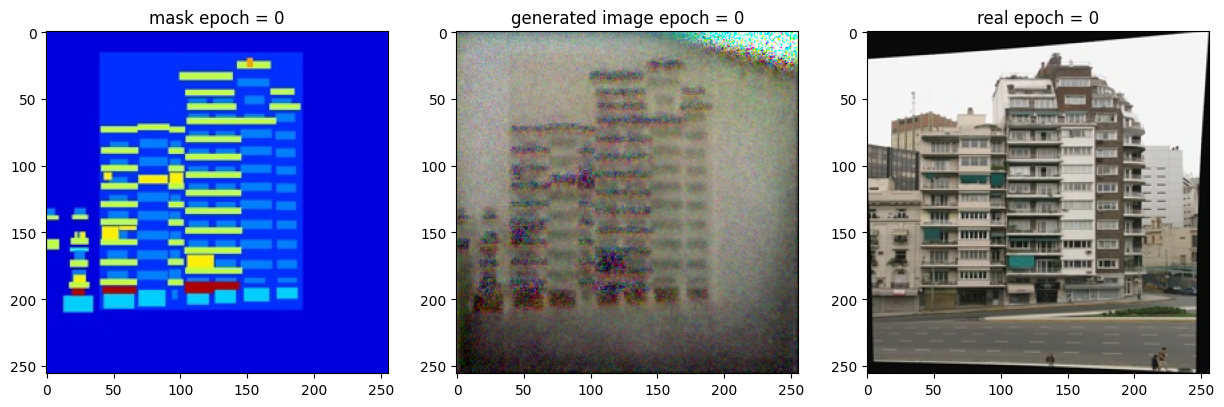

Step:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch num 2, step 37, desc_loss: 0.2424, gen_loss: 20.3226, gen bce loss 1.1114

Step:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch num 3, step 37, desc_loss: 0.3656, gen_loss: 24.9238, gen bce loss 4.2376

Step:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch num 4, step 37, desc_loss: 0.2864, gen_loss: 25.3460, gen bce loss 2.7188

Step:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch num 5, step 37, desc_loss: 0.2765, gen_loss: 20.3430, gen bce loss 2.8081

Step:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch num 6, step 37, desc_loss: 1.0515, gen_loss: 24.4632, gen bce loss 1.9107

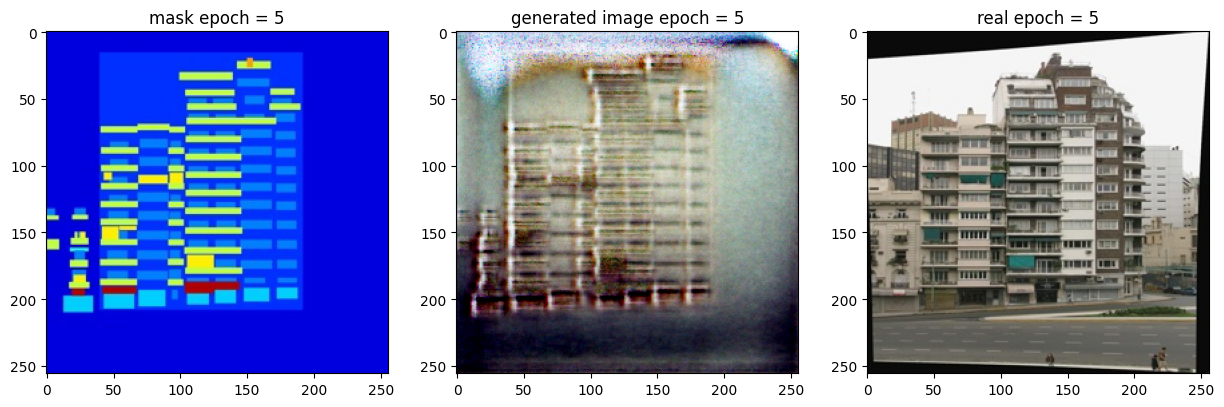

Step:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch num 7, step 37, desc_loss: 0.9528, gen_loss: 22.5906, gen bce loss 2.4722

Step:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch num 8, step 37, desc_loss: 0.3613, gen_loss: 20.7895, gen bce loss 1.4060

Step:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch num 9, step 37, desc_loss: 0.4260, gen_loss: 23.1562, gen bce loss 5.4469

Step:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch num 10, step 37, desc_loss: 0.7099, gen_loss: 16.3626, gen bce loss 0.3908

Step:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch num 11, step 37, desc_loss: 0.2524, gen_loss: 21.2351, gen bce loss 1.3906

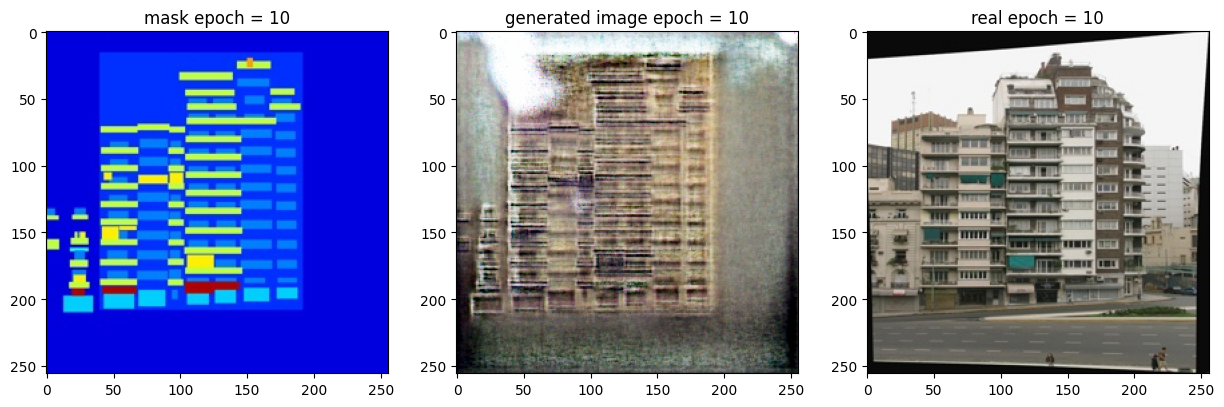

Step:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch num 12, step 37, desc_loss: 0.6648, gen_loss: 17.6727, gen bce loss 0.1694

Step:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch num 13, step 37, desc_loss: 0.3752, gen_loss: 21.0578, gen bce loss 1.5495

Step:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch num 14, step 37, desc_loss: 0.3919, gen_loss: 17.7256, gen bce loss 1.0944

Step:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch num 15, step 37, desc_loss: 0.3981, gen_loss: 18.2666, gen bce loss 2.0634

Step:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch num 16, step 37, desc_loss: 0.5619, gen_loss: 20.5556, gen bce loss 1.1923

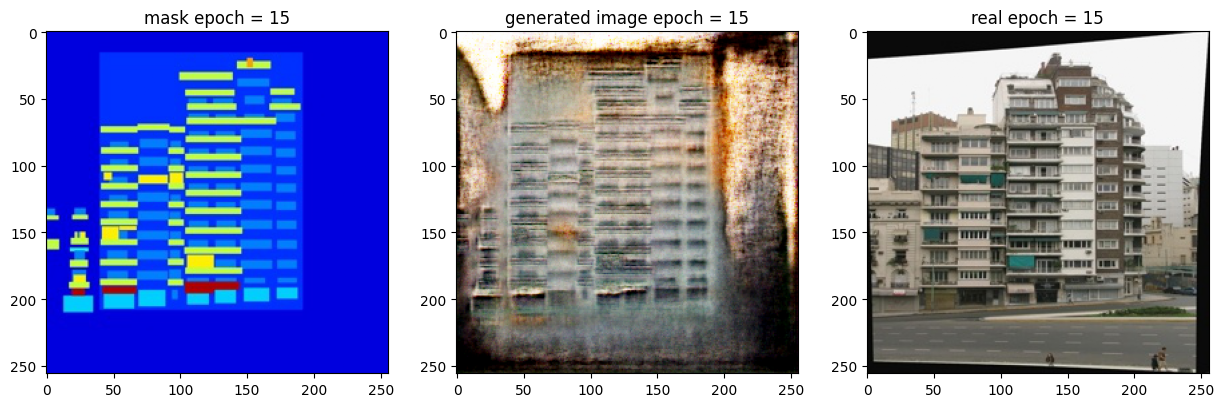

Step:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch num 17, step 37, desc_loss: 0.4040, gen_loss: 20.6539, gen bce loss 3.3953

Step:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch num 18, step 37, desc_loss: 0.8680, gen_loss: 17.8427, gen bce loss 2.8550

Step:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch num 19, step 37, desc_loss: 0.3687, gen_loss: 18.0834, gen bce loss 1.1769

Step:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch num 20, step 37, desc_loss: 0.2611, gen_loss: 20.4436, gen bce loss 1.4964

Step:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch num 21, step 37, desc_loss: 0.1470, gen_loss: 18.5186, gen bce loss 2.2412

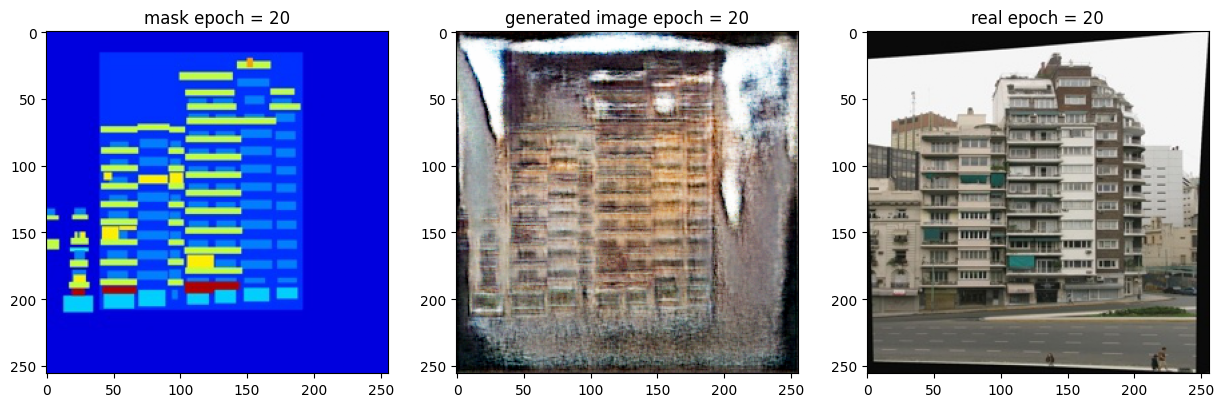

Step:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch num 22, step 37, desc_loss: 0.5558, gen_loss: 19.4951, gen bce loss 0.6669

Step:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch num 23, step 37, desc_loss: 0.4344, gen_loss: 16.2991, gen bce loss 1.3368

Step:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch num 24, step 37, desc_loss: 0.5506, gen_loss: 17.4994, gen bce loss 1.7743

Step:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch num 25, step 37, desc_loss: 1.6969, gen_loss: 17.1411, gen bce loss 0.6895

Step:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch num 26, step 37, desc_loss: 0.9279, gen_loss: 21.4020, gen bce loss 2.4947

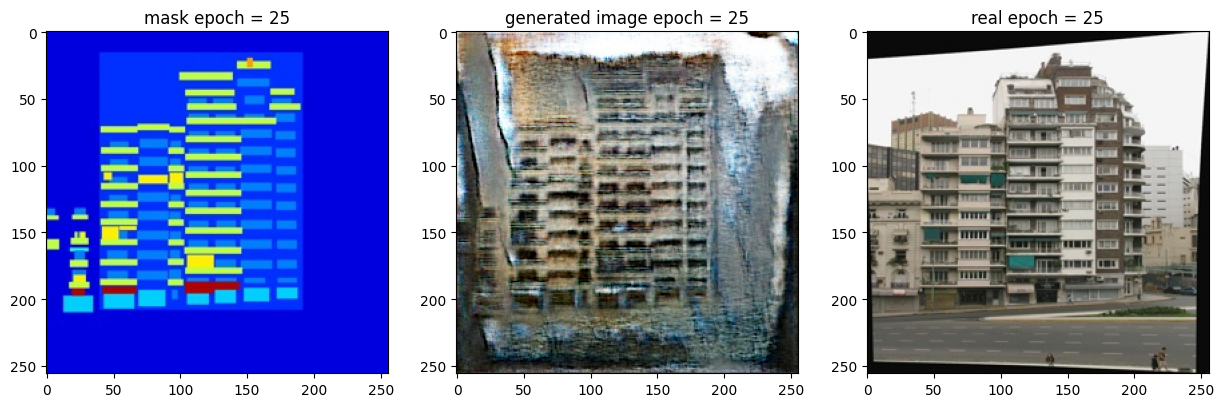

Step:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch num 27, step 37, desc_loss: 0.3642, gen_loss: 16.5458, gen bce loss 1.9427

Step:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch num 28, step 37, desc_loss: 0.7428, gen_loss: 15.3819, gen bce loss 0.3527

Step:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch num 29, step 37, desc_loss: 0.4947, gen_loss: 16.6044, gen bce loss 0.3082

Step:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch num 30, step 37, desc_loss: 0.2625, gen_loss: 17.6492, gen bce loss 2.3745

Step:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch num 31, step 37, desc_loss: 0.9385, gen_loss: 20.3224, gen bce loss 3.4141

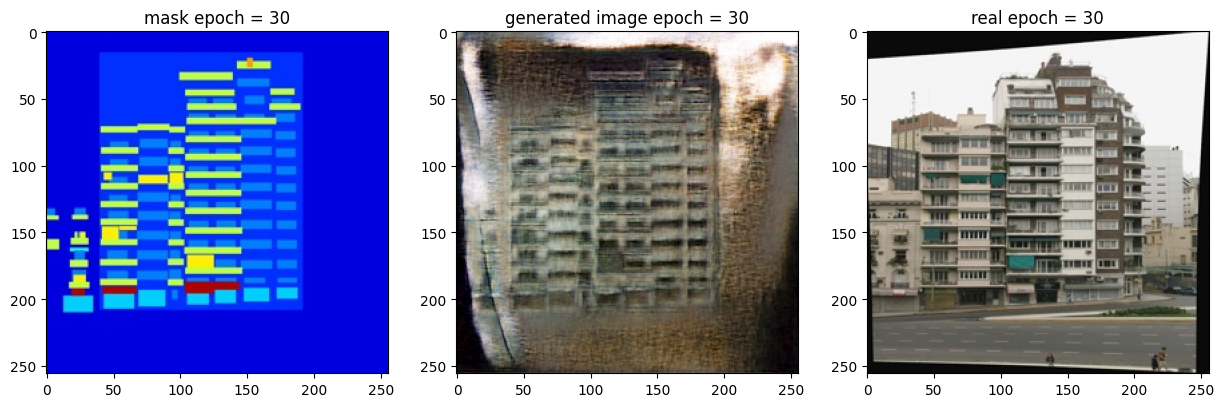

Step:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch num 32, step 37, desc_loss: 0.3571, gen_loss: 14.7130, gen bce loss 0.6492

Step:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch num 33, step 37, desc_loss: 0.5284, gen_loss: 19.7460, gen bce loss 2.0383

Step:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch num 34, step 37, desc_loss: 0.8218, gen_loss: 18.1040, gen bce loss 2.2362

Step:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch num 35, step 37, desc_loss: 0.9358, gen_loss: 14.5319, gen bce loss 0.4201

Step:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch num 36, step 37, desc_loss: 1.1801, gen_loss: 14.4890, gen bce loss 0.1605

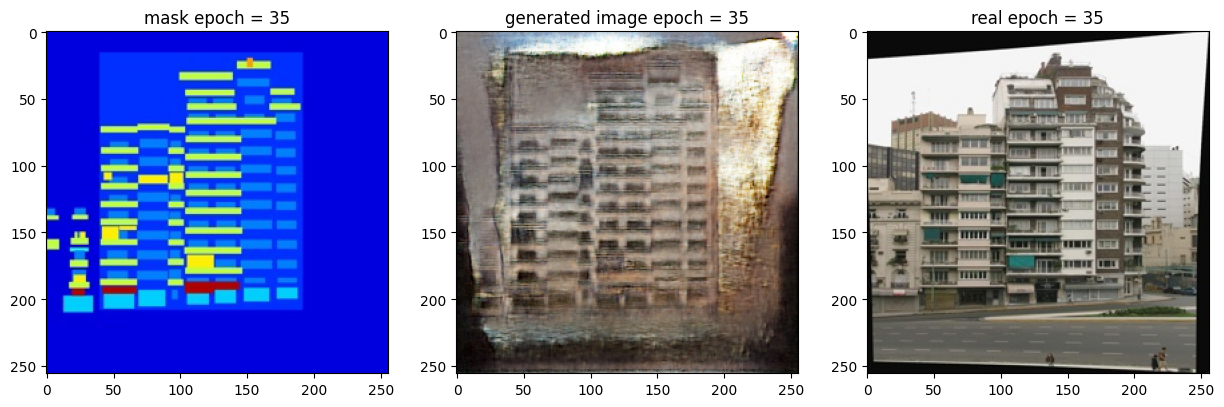

Step:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch num 37, step 37, desc_loss: 0.5398, gen_loss: 15.2313, gen bce loss 0.8985

Step:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch num 38, step 37, desc_loss: 0.6378, gen_loss: 16.5475, gen bce loss 0.4945

Step:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch num 39, step 37, desc_loss: 0.3862, gen_loss: 16.2799, gen bce loss 0.7950

Step:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch num 40, step 37, desc_loss: 0.3425, gen_loss: 17.0664, gen bce loss 1.2172

Step:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch num 41, step 37, desc_loss: 0.4483, gen_loss: 14.2439, gen bce loss 1.7331

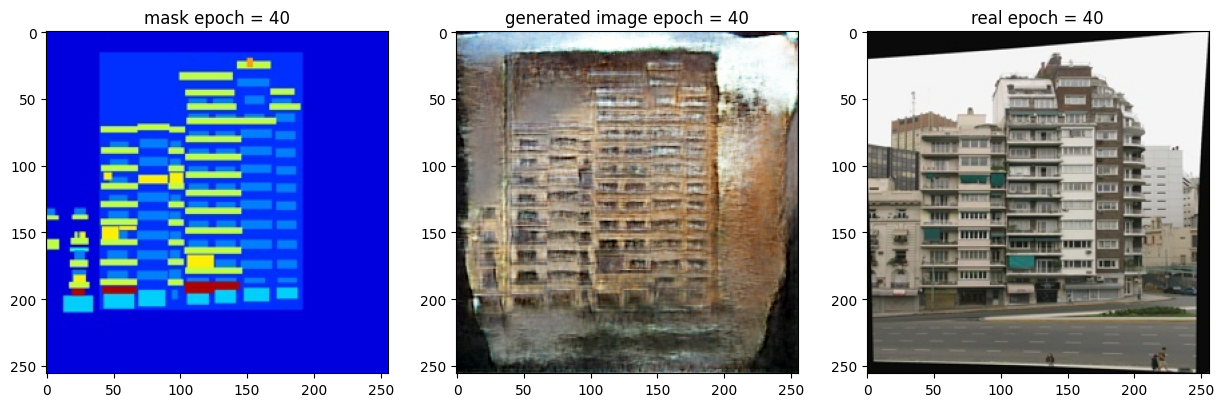

Step:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch num 42, step 37, desc_loss: 0.5438, gen_loss: 14.6552, gen bce loss 1.4365

Step:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch num 43, step 37, desc_loss: 0.5093, gen_loss: 16.5371, gen bce loss 1.0842

Step:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch num 44, step 37, desc_loss: 0.4859, gen_loss: 14.0130, gen bce loss 0.1065

Step:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch num 45, step 37, desc_loss: 0.4697, gen_loss: 15.7784, gen bce loss 2.4101

Step:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch num 46, step 37, desc_loss: 1.0108, gen_loss: 16.8491, gen bce loss 3.2802

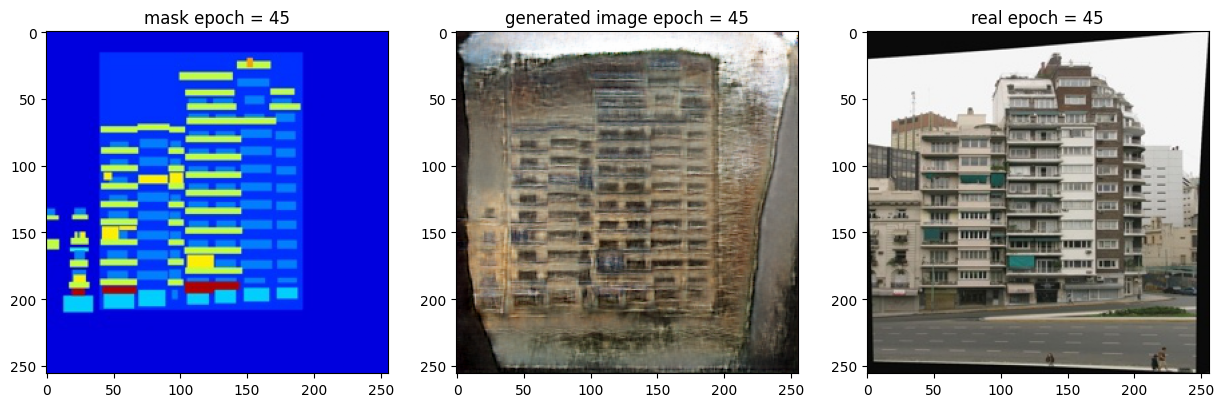

Step:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch num 47, step 37, desc_loss: 0.8716, gen_loss: 14.2000, gen bce loss 0.2036

Step:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch num 48, step 37, desc_loss: 0.4725, gen_loss: 16.5638, gen bce loss 1.9949

Step:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch num 49, step 37, desc_loss: 0.2736, gen_loss: 16.0122, gen bce loss 1.7934

Step:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch num 50, step 37, desc_loss: 0.6315, gen_loss: 15.9020, gen bce loss 0.7190

In [11]:
pix_model = Pix2pix()
pix_model.train_pix()

In [10]:
def loss_plot(arr, name=""):
    sns.set_style("darkgrid")
    plt.plot(arr)
    plt.title(f"{name}")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()


Generator loss снижался

## Вторая часть -- реализация CycleGAN

In [11]:
from PIL import Image


def read_path(path):
    all_path = "/content/drive/MyDrive/facades/" + path + "/"
    dataset = []
    for p in glob.glob(all_path + "*.jpg"):
        dataset.append(p)
    return dataset


class Dataset_new(object):
    def __init__(self, path):
        self.files = read_path(path)
        self.trasformer = transforms.Compose([

            transforms.ToTensor(),
            # transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
        ])

    def _sep(self, img):
        img_np = np.array(img)
        mask_image = img_np[:, img.width // 2:]
        real_image = img_np[:, :img.width // 2]
        return mask_image, real_image

    def __getitem__(self, idx):
        img_1 = Image.open(random.choice(self.files)).convert('RGB')
        img_2 = Image.open(random.choice(self.files)).convert("RGB")
        width = img_2.width
        img_11 = np.array(img_1)[:, width // 2:]
        img_22 = np.array(img_2)[:, :width // 2]
        return self.trasformer(img_11), self.trasformer(img_22)

    def __len__(self):
        return len(self.files)


train_ds = Dataset_new("train")
train_dl_2 = torch.utils.data.DataLoader(train_ds, batch_size=3, shuffle=True)

val_ds = Dataset_new("val")
val_dl_2 = torch.utils.data.DataLoader(val_ds, batch_size=1, shuffle=False)


In [12]:
class Discriminator_new(nn.Module):
    def __init__(self, in_c=3, out_c=64):
        super().__init__()
        """ Encoder 2 and 3 """
        self.c11 = nn.Conv2d(in_c, out_c, kernel_size=3, padding=1)
        # self.br1 = batchnorm_relu(out_c)
        self.r1 = res_blok(out_c, out_c * 2, stride=2)
        self.r2 = res_blok(out_c * 2, out_c * 4, stride=2)
        self.r3 = res_blok(out_c * 4, out_c * 8, stride=2)
        self.r4 = res_blok(out_c * 8, out_c * 8, stride=2)

        """ Output """
        self.pooling = nn.AdaptiveAvgPool2d((1, 1))
        self.output = nn.Linear(out_c * 8, 2)

    def forward(self, x):
        x = self.c11(x)
        skip1 = self.r1(x)
        skip2 = self.r2(skip1)
        skip3 = self.r3(skip2)
        skip4 = self.r4(skip3)

        output = self.pooling(skip4)
        output = output.squeeze(-1).squeeze(-1)
        output = torch.nn.Sigmoid()(output)
        return output


In [13]:
from torchvision.utils import make_grid
import torchvision.transforms.functional as F
plt.rcParams["savefig.bbox"] = 'tight'

def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs),figsize=(15, 5), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
    plt.show()


def plot_val(gen_1, gen_2, epoch, device):
    gen_1.eval()
    gen_2.eval()
    print(f'Epoch: {epoch}')
    for im_1, im_2 in val_dl_2:
        gen_img = im_1.to(device)
        gen_mask = im_2.to(device)
        gen_mask_fake = gen_1(gen_img).cpu().detach()
        gen_img_fake = gen_2(gen_mask).cpu().detach()
        img_to_show = torch.cat([gen_img.cpu(), gen_img_fake, gen_mask.cpu(), gen_mask_fake], dim=0)
        show(make_grid(img_to_show))
        break

In [19]:
class Cycle_Gan:
    def __init__(self):
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        print(f'device={self.device}')
        self.gen_1 = Generator().to(self.device)
        self.gen_2 = Generator().to(self.device)
        self.disc_1 = Discriminator_new().to(self.device)
        self.disc_2 = Discriminator_new().to(self.device)

        self.desc_1_opt = torch.optim.Adam(self.disc_1.parameters(), lr=2e-4, betas=(0.5, 0.999))
        self.desc_2_opt = torch.optim.Adam(self.disc_2.parameters(), lr=2e-4, betas=(0.5, 0.999))

        self.gen_opt = torch.optim.Adam(list(self.gen_1.parameters()) + list(self.gen_2.parameters()),
                                        lr=1e-4)
        self.l_loss = torch.nn.L1Loss()
        self.bce_loss = torch.nn.CrossEntropyLoss()

        self.disc_1_all_loss_mean = []
        self.disc_2_all_loss_mean = []
        self.gen_1_2_all_loss_mean = []
        self.epochs = 25
    def train_cycle(self):

        for epoch in tqdm(range(self.epochs ), desc='Epoch'):
            disc_1_all_loss_ = []
            disc_2_all_loss_ = []
            gen_1_2_all_loss_ = []
            for i, batch in tqdm(enumerate(train_dl_2), total=len(train_dl_2), leave=False, position=0, desc='Step'):
                mask_img, real_img = batch
                mask_img = mask_img.to(self.device)
                real_img = real_img.to(self.device)

                gen_img = self.gen_1(mask_img)
                gen_mask = self.gen_2(real_img)
                gen_mask_l = self.disc_1(gen_mask)
                real_mask_l = self.disc_1(mask_img)
                gen_img_l = self.disc_2(gen_img)
                real_img_l = self.disc_2(real_img)

                gen_loss_disc_1 = self.bce_loss(gen_mask_l, torch.zeros(gen_mask_l.shape[0]).long().to(self.device))
                real_loss_disc_1 = self.bce_loss(real_mask_l, torch.ones(real_mask_l.shape[0]).long().to(self.device))
                disc_1_all_loss = (gen_loss_disc_1 + real_loss_disc_1) / 2
                self.desc_1_opt.zero_grad()
                disc_1_all_loss.backward()
                self.desc_1_opt.step()

                gen_loss_disc_2 = self.bce_loss(gen_img_l,
                                                torch.zeros(gen_img_l.shape[0]).long().to(
                                                    self.device))
                real_loss_disc_2 = self.bce_loss(real_img_l,
                                                 torch.ones(real_img_l.shape[0]).long().to(self.device))
                disc_2_all_loss = (gen_loss_disc_2 + real_loss_disc_2) / 2
                self.desc_2_opt.zero_grad()
                disc_2_all_loss.backward()
                self.desc_2_opt.step()

                gen_img = self.gen_1(mask_img)
                gen_mask = self.gen_2(real_img)
                generated_images_cycle = self.gen_1(gen_mask)
                generated_masks_cycle = self.gen_2(gen_img)
                gen_l1_loss = (self.l_loss(mask_img, generated_masks_cycle) + self.l_loss(real_img,
                                                                                          generated_images_cycle)) / 2
                gen_l2_loss = (self.l_loss(mask_img, gen_mask) + self.l_loss(real_img,
                                                                             gen_img)) / 2
                gen_mask_l = self.disc_1(gen_mask)
                gen_img_l = self.disc_2(gen_img)
                gen_1_bce = self.bce_loss(gen_img_l,
                                          torch.ones(gen_img_l.shape[0]).long().to(self.device))
                gen_2_bce = self.bce_loss(gen_mask_l,
                                          torch.ones(gen_mask_l.shape[0]).long().to(self.device))
                gen_1_2_all_loss = 20 * gen_l1_loss + gen_1_bce + 20 * gen_l2_loss + gen_2_bce
                self.gen_opt.zero_grad()
                gen_1_2_all_loss.backward()
                self.gen_opt.step()

                print(
                    '\rEpoch num {}, step {}, Discriminator 1 loss: {:.4f}, Discriminator 2 loss: {:.4f}, Generator loss {:.4f}'.format \
                        (epoch + 1, i + 1, disc_1_all_loss.item(), disc_2_all_loss.item(), gen_1_2_all_loss.item()),
                    end='', flush=True)
                disc_1_all_loss_.append(disc_1_all_loss.item())
                disc_2_all_loss_.append(disc_2_all_loss.item())
                gen_1_2_all_loss_.append(gen_1_2_all_loss.item())
            if epoch % 10 == 0:
                plot_val(self.gen_1, self.gen_2, epoch, self.device)
        self.disc_1_all_loss_mean.append(np.mean(disc_1_all_loss_))
        self.disc_2_all_loss_mean.append(np.mean(disc_2_all_loss_))
        self.gen_1_2_all_loss_mean.append(np.mean(gen_1_2_all_loss_))


device=cuda


Epoch:   0%|          | 0/25 [00:00<?, ?it/s]

Step:   0%|          | 0/134 [00:00<?, ?it/s]

Epoch num 1, step 134, Discriminator 1 loss: 5.2452, Discriminator 2 loss: 5.2452, Generator loss 18.5959Epoch: 0


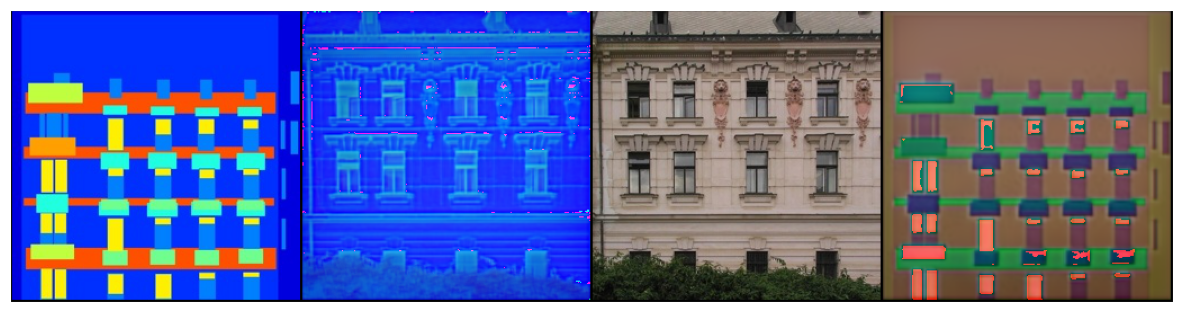

Step:   0%|          | 0/134 [00:00<?, ?it/s]

Epoch num 2, step 17, Discriminator 1 loss: 5.2452, Discriminator 2 loss: 5.2451, Generator loss 16.0740

In [ ]:
%%time
cycle_gan_model = Cycle_Gan()
cycle_gan_model.train_cycle()


In [ ]:
loss_plot(cycle_gan_model.gen_1_2_all_loss_mean, name="Generator losses")

К сожалению из-за нехватки времени не удалось доделать и нормально протестировать.